In [6]:
! pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Code for Fine Tuning

Configuration of the process

### Loading the dataset

Load the dataset: Human Parsing Data from

In [13]:
from datasets import load_dataset

# load the dataset and split the train-test
dataset_identifier = "mattmdjaga/human_parsing_dataset"
ds = load_dataset(dataset_identifier, split="train[:100%]", num_proc=8)
ds.shuffle(seed=1)

split_ratio = 0.006
split_size = int(len(ds) * split_ratio)
print(f"Split size: {split_size}")

ds_split = ds.train_test_split(test_size=split_ratio, seed=1)
train_ds = ds_split["train"]
test_ds = ds_split["test"]

Split size: 106


Check the samples

In [14]:
ds

Dataset({
    features: ['image', 'mask'],
    num_rows: 17706
})

There are 17706 samples in this dataset. We split 106 of them for testing.

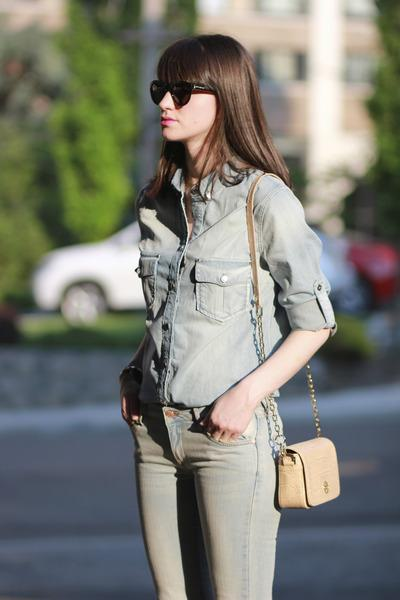

In [18]:
example = ds_split["train"][1]
example["image"]

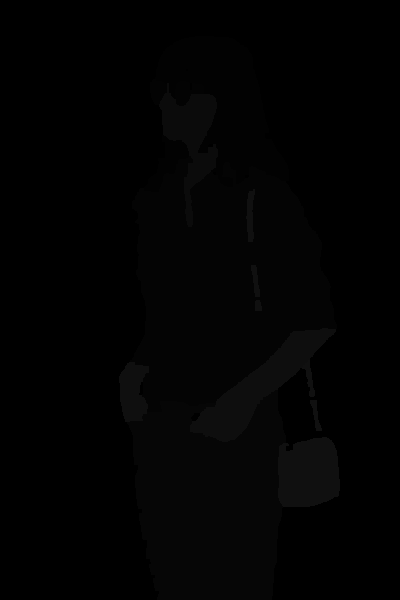

In [19]:
example["mask"]

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training.

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

### Preprocessing the data

### Training the model

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The performance of the original model before fine tuning.

In [1]:
from transformers import AutoFeatureExtractor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [65]:
# apple model performance
model_name = "apple/deeplabv3-mobilevit-small"
original_processor = AutoFeatureExtractor.from_pretrained(model_name)
original_processor.do_center_crop = False
original_model = AutoModelForSemanticSegmentation.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# load the image
url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"
image = Image.open(requests.get(url, stream=True).raw)

# pre-process the image
inputs = original_processor(images=image, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = original_model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg_original = upsampled_logits.argmax(dim=1)[0].cpu()

/usr/local/lib/python3.10/dist-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


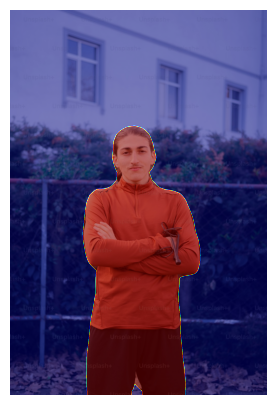

In [66]:
# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg_original, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

Model after fine tuning.

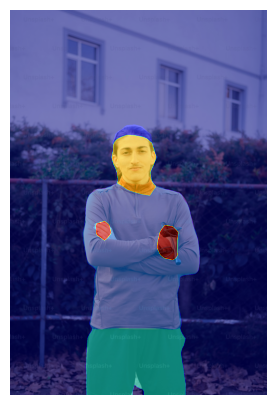

In [68]:
# load the model from fine tuning
model_dir = "./7"

model = AutoModelForSemanticSegmentation.from_pretrained(model_dir).to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu()

# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

# Applying the Lut to the image

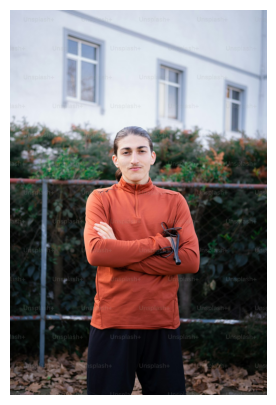

In [69]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.axis("off")
plt.show()

In [54]:
pip install pillow pillow-lut

  Preparing metadata (setup.py) ... done
  Created wheel for pillow-lut: filename=pillow_lut-1.0.1-py3-none-any.whl size=10473 sha256=e3a572be4feb9011ef30f0e3639b9489d199ec4203c65a20068eee8611796f5b
  Stored in directory: /root/.cache/pip/wheels/c1/c9/b0/e80cbc8b67d6d193d9932946a0570a363175a192df879a8436
Successfully built pillow-lut


In [70]:
from PIL import Image
from pillow_lut import load_cube_file

lut = load_cube_file("./Summer.cube")
im = Image.open("1.jpeg")
im.filter(lut).save("image-with-lut-applied.png")

Start to apply filter to part of the image.

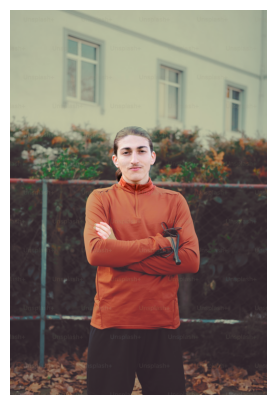

In [72]:
from PIL import Image
import numpy as np

# load the image
# im = Image.open("1.jpeg")
im = image
im_lut = Image.open("image-with-lut-applied.png")
# mask = Image.open("mask.png")
mask = pred_seg

# change to NumPy array
mask_array = np.array(mask)
im_array = np.array(im)
im_lut_array = np.array(im_lut)

# categories for skin
categories_to_keep = [11, 12, 13, 15]

# mask for skin
keep_mask = np.isin(mask_array, categories_to_keep)

final_image_array = np.where(keep_mask[..., None], im_array, im_lut_array)

# save and plot the image
final_image = Image.fromarray(final_image_array.astype('uint8'))
final_image.save("final_image2.png")
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(final_image)
ax.axis("off")
plt.show()

summarize how many pixel points in each class in the mask image.

In [57]:
# pred_seg

unique_values, counts = torch.unique(pred_seg, return_counts=True)

# make a table
table = {int(value.item()): count.item() for value, count in zip(unique_values, counts)}

# print result
print("Value - Count")
for value, count in table.items():
    print(f"{value} - {count}")

Value - Count
0 - 1158071
1 - 90
2 - 6207
4 - 210231
6 - 94859
11 - 23773
14 - 21
15 - 2127
16 - 4621
